# Collision Detection Notebook
Implementation of 3D Collision Detection Algorithms

********************************************************************************************

In [1]:
import time
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import numba
import pyvista as pv

In [2]:
from primitives.triangle import Triangle
from scenes.scene import Scene
from scenes.render import render_scene
from utils.misc import get_floor

/Users/dipanjan/anaconda3/envs/Primitive-Intersection/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


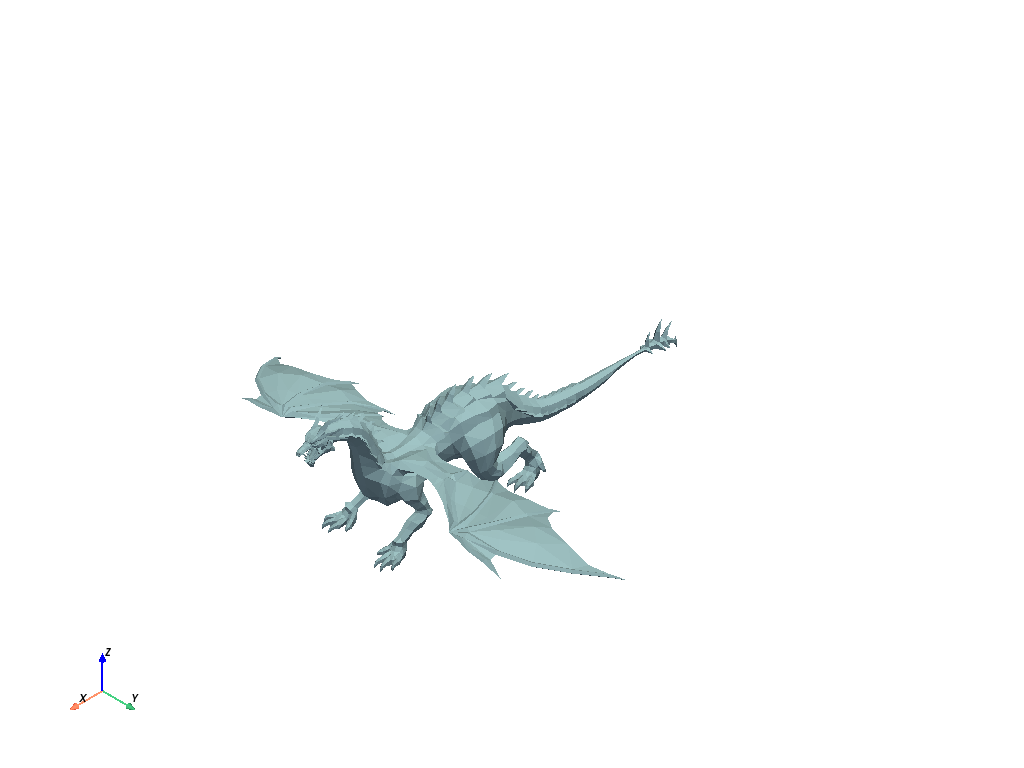

In [3]:
#load object

sphere_path = "objects/sphere.obj"
cylinder_path = "objects/cylinder.obj"
rabbit = "objects/rabbit.obj"
carrot = "objects/carrot.obj"
plane = "objects/plane.obj"
squirrel = "objects/squirrel.obj"
tree = "objects/broad_deciduous_tree_green_leaves.obj"
ant = "objects/ant.obj"
fireball = "objects/fireball.obj"
dragon = "objects/dragon.obj"


file_path = dragon

path = Path(file_path).resolve()
mesh = pv.read(path)
mesh.plot()


In [4]:
# Example: 15k primitives - helmet object


# from pyvista import examples
#
# helmet_file = examples.gltf.download_damaged_helmet()
# texture = examples.download_dikhololo_night()
#
# pl = pv.Plotter()
# pl.import_gltf(helmet_file)
# pl.set_environment_texture(texture)
# pl.camera.zoom(1.7)
# pl.show()

In [5]:
# block = pv.read(helmet_file)
# mesh = block[0][0][0]
# mesh.plot(color='lightblue', show_edges=True, cpos='xy')

In [6]:
mesh = mesh.triangulate()
points = np.ascontiguousarray(mesh.points)
points

array([[-1.42032, -3.84453,  7.84104],
       [-1.20234, -3.05889,  7.51012],
       [-0.28715, -4.66891,  7.69354],
       ...,
       [ 2.48916, -0.38293,  8.22615],
       [ 2.7045 , -1.08761,  8.75081],
       [ 2.24759, -1.08761,  8.40765]], dtype=float32)

In [7]:
points = np.ascontiguousarray(mesh.points)
faces = mesh.faces.reshape((-1,4))[:, 1:4]
vertices = np.ascontiguousarray(points[faces], dtype=np.float64)

In [8]:
# Initialise an empty list for primitives
objects = numba.typed.List()

In [9]:
# Add the triangles in the list of objects
for v in vertices:
    a,b,c = v[0], v[1], v[2]

    triangle = Triangle(vertex_1=np.ascontiguousarray(a, dtype=np.float64),
                                   vertex_2=np.ascontiguousarray(b, dtype=np.float64),
                                   vertex_3=np.ascontiguousarray(c, dtype=np.float64))
    objects.append(triangle)

objects

ListType[instance.jitclass.Triangle#129496760<vertex_1:array(float64, 1d, A),vertex_2:array(float64, 1d, A),vertex_3:array(float64, 1d, A),centroid:array(float64, 1d, A),normal:array(float64, 1d, A)>]([<numba.experimental.jitclass.boxing.Triangle object at 0x13f8f2460>, <numba.experimental.jitclass.boxing.Triangle object at 0x13e3180d0>, <numba.experimental.jitclass.boxing.Triangle object at 0x13f8f2460>, <numba.experimental.jitclass.boxing.Triangle object at 0x13e3180d0>, <numba.experimental.jitclass.boxing.Triangle object at 0x13f8f2460>, <numba.experimental.jitclass.boxing.Triangle object at 0x13e3180d0>, <numba.experimental.jitclass.boxing.Triangle object at 0x13f8f2460>, <numba.experimental.jitclass.boxing.Triangle object at 0x13e3180d0>, <numba.experimental.jitclass.boxing.Triangle object at 0x13f8f2460>, <numba.experimental.jitclass.boxing.Triangle object at 0x13e3180d0>, <numba.experimental.jitclass.boxing.Triangle object at 0x13f8f2460>, <numba.experimental.jitclass.boxing.Tri

In [10]:
from utils.vectors import normalize

# Calculate the bounding box of the point cloud
centroid = mesh.center

min_p = np.min(vertices)-5

centroid, min_p

([-13.612534046173096, -1.0876045227050781, 7.944965001195669],
 -43.542808532714844)

In [11]:
# Define the camera parameters based on the bounding box
camera = centroid + np.array([0.0, 0.0, min_p])  # Position behind the centroid
look_at = normalize(centroid - camera)  # Looking towards the centroid
camera, look_at

(array([-13.61253405,  -1.08760452, -35.59784353]), array([0., 0., 1.]))

In [12]:
# Setup scene

# screen
width=300
height=300


# Initialise the scene with lights and camera
scene = Scene(look_at=look_at, camera=camera, width=width, height=height)

In [13]:
from accelerators.bvh import BoundedBox

# Enclose all the primitives in their individual axis-aligned bounding boxes (AABB)
bounded_boxes = []
for i in range(len(objects)):
    bounded_boxes.append(BoundedBox(objects[i], i))

len(objects), len(bounded_boxes)

(4798, 4798)

In [14]:
from accelerators.bvh import build_bvh

# Initialise a bounding volume hierarchy tree
start = 0
end = len(bounded_boxes)
ordered_prims = []
total_nodes = 0
split_method = 2 # 0: surface area heuristics, 1: mid-point, 2: equal parts
root, _, ordered_prims, total_nodes = build_bvh(objects, bounded_boxes, start, end, ordered_prims, total_nodes, split_method)
# swap the primitives array with the ordered list
primitives = ordered_prims
# root node of the bvh tree
root

In [15]:
from accelerators.bvh import LinearBVHNode

# create a linear representation of the bvh tree (empty)
linear_bvh = numba.typed.List()
for _ in range(total_nodes):
    linear_bvh.append(LinearBVHNode())

len(linear_bvh) # equals to the number of nodes in the original tree

9591

In [16]:
from accelerators.bvh import flatten_bvh

# add nodes to the empty linear tree
_offset = flatten_bvh(linear_bvh, root, [0])
len(linear_bvh), _offset

(9591, 0)

In [17]:
# ** render function without progress bar **

# from scenes.render import _render_scene
#
# start = time.time()
# # primitives = spheres, triangles
# image = _render_scene(scene, objects, linear_bvh)
# end = time.time()
# print("Elapsed (with compilation) = %s" % (end - start))

In [20]:
from numba_progress import ProgressBar

num_iterations = scene.height

start = time.time()

with ProgressBar(total=num_iterations, ncols=80) as numba_progress1, ProgressBar(total=num_iterations, ncols=80) as numba_progress2:
    image = render_scene(scene, objects, linear_bvh, (numba_progress1, numba_progress2))

end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Elapsed (with compilation) = 0.2083437442779541


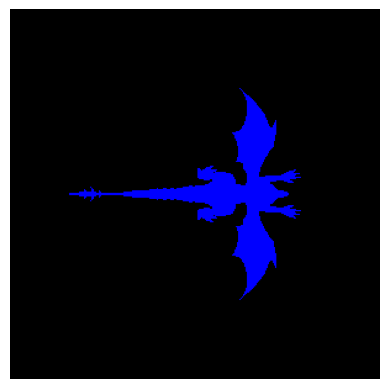

In [21]:
plt.imshow(image)
plt.axis('off')
plt.show()